<a href="https://colab.research.google.com/github/yinghaow525/MSBA-Projects/blob/main/Capstone%20Project/Capstone_A6_Coding_Deliverable_06_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsone Project with Spinnaker Analytics
Team A6: Yihan Jia, Yinghao Wang, Simeng Li, Xiangshan Mu, Kaiyu Wang
> **Business Objectives**:
- The objective of the exercise is to find a tradable signal in the dataset. 

> **Project Flow**:
- Standard time series models can be used or non-parametric models like neural networks can be deployed. Suggested course of actions is as follows:
  1. Understand the dataset and what it represents
  2. Define the problem: what does 'a tradable signal' mean based on the data available (i.e. develop your modeling equation, if any)
  3. Start with simple analysis to identify patterns and outliers
  4. Develop models with increasing complexity - i.e. don't start with neural nets etc
  5. Define your success criteria - i.e. when do you know you have a tradable signal - positive (buy)/negative (sell), both are signals


In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from google.colab import drive

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima_model import ARIMA



from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, neural_network
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support

#reset recursionlimit
import sys
sys.setrecursionlimit(10000)

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

# supress filter warnings
import warnings
warnings.filterwarnings("ignore")

#plt style
plt.style.use("seaborn")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Multi-Class Classification 


In [ ]:
# ETF (Exchange Traded Funds - insitutional investors)
ETF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Inst%20ETF.csv')
# Institutional Mutual Fund Holdings 
IMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Institutional%20MF.csv')
# Retail Mutual Fund Holdings (investments made by individuals in their portfolios
RMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Retail%20MF.csv')

In [ ]:
ETF.head(3)

,ReportDate,AssetClass,Flow,FlowPct,AssetsEnd,PortfolioChangePct
0,2/1/2017 12:00:00 AM,Commodities/Materials-North America-USA-North ...,378.578706,4.5064,8679.056347,-1.1938
1,2/1/2017 12:00:00 AM,Consumer Goods-North America-USA-North America...,332.526792,1.1479,28973.613065,-1.1231
2,2/1/2017 12:00:00 AM,Energy-North America-USA-North America-Equity,186.031374,0.3782,48446.700077,-1.8855


In [ ]:
# Create type colunm
ETF['Type'] = 'ETF'
IMF['Type'] = 'IMF'
RMF['Type'] = 'RMF'

# Concat 3 dadaset
data = pd.concat([ETF, IMF, RMF], axis=0)

In [ ]:
# convert report date to pandas datetime object
data['ReportDate'] = pd.to_datetime(data['ReportDate'])

In [ ]:
# since all the Asset and Sector values are the same (Equity, and within US)
# we only keep Industry sector as features
data['AssetClass'] = data['AssetClass'].str.split('-')
data['Industry'] = data.AssetClass.apply(lambda x: x[0])

# drop orignal AssetClass feature
data.drop(columns='AssetClass', inplace=True)

# types and number of Industry values
data.Industry.value_counts()

Mid Cap Growth           1737
Technology               1737
Energy                   1737
Financials               1737
Health Care/Biotech      1737
Utilities                1737
Large Cap Blend          1737
Large Cap Growth         1737
Large Cap Value          1737
Mid Cap Blend            1737
Telecom                  1737
Mid Cap Value            1737
Real Estate              1737
Small Cap Blend          1737
Small Cap Growth         1737
Small Cap Value          1737
Commodities/Materials    1700
Consumer Goods           1700
Industrials              1435
Infrastructure             61
Name: Industry, dtype: int64

In [ ]:
data.head(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry
0,2017-02-01,378.578706,4.5064,8679.056347,-1.1938,ETF,Commodities/Materials
1,2017-02-01,332.526792,1.1479,28973.613065,-1.1231,ETF,Consumer Goods
2,2017-02-01,186.031374,0.3782,48446.700077,-1.8855,ETF,Energy


In [ ]:
data = data.sort_values(by=['ReportDate'])

In [ ]:
# extract year & month 
data['year'], data['month'] = data['ReportDate'].dt.year, data['ReportDate'].dt.month
data.head(12)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month
10667,2006-01-04,-9.076384,-0.2789,3293.597159,1.5210,RMF,Utilities,2006,1
10989,2006-01-04,5.144223,2.4847,213.485252,0.6311,ETF,Industrials,2006,1
10988,2006-01-04,45.038766,1.7847,2601.925992,1.3221,ETF,Health Care/Biotech,2006,1
10987,2006-01-04,0.000000,0.0000,501.334569,0.8235,ETF,Financials,2006,1
10986,2006-01-04,12.115391,0.7262,1756.771759,4.5757,ETF,Energy,2006,1
10985,2006-01-04,11.761774,1.8150,662.337236,0.3959,ETF,Consumer Goods,2006,1
10984,2006-01-04,23.148567,6.8877,365.747363,1.9393,ETF,Commodities/Materials,2006,1
10666,2006-01-04,-0.065491,-0.3344,19.953725,2.2451,RMF,Telecom,2006,1
11015,2006-01-04,2.025772,0.4645,442.631215,1.0439,IMF,Telecom,2006,1
11014,2006-01-04,-866.881534,-35.0908,1615.664999,0.4920,IMF,Technology,2006,1


In [ ]:
data.head(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month
10667,2006-01-04,-9.076384,-0.2789,3293.597159,1.5210,RMF,Utilities,2006,1
10989,2006-01-04,5.144223,2.4847,213.485252,0.6311,ETF,Industrials,2006,1
10988,2006-01-04,45.038766,1.7847,2601.925992,1.3221,ETF,Health Care/Biotech,2006,1


In [ ]:
data.shape

(32688, 9)

In [ ]:
data = data.sort_values(by=['Type', 'Industry','year','month','ReportDate'])
data = data.reset_index(drop=True)

In [ ]:
# 删除符合条件的指定行，并替换原始df
data.drop(data[(data.year == 2017) & (data.month == 2)].index, inplace=True)
data.drop(data[data.Industry == 'Infrastructure'].index, inplace=True)

data.drop(data[(data.year == 2006) & (data.month == 9) & (data.Industry == 'Commodities/Materials') & (data.Type == 'RMF')].index, inplace=True)
data.drop(data[(data.year == 2006) & (data.month == 9) & (data.Industry == 'Consumer Goods') & (data.Type == 'RMF')].index, inplace=True)
data.drop(data[(data.year == 2011) & (data.month == 10) & (data.Industry == 'Industrials') & (data.Type == 'RMF')].index, inplace=True)

In [ ]:
data.shape

(32564, 9)

In [ ]:
def converter(x):
    return pd.Series({
        'Flow':sum(x.Flow.unique()),
        'FlowPct1':x.FlowPct[:1].unique()[0],
        'FlowPct4':x.FlowPct.unique()[-1],
        'AssetsEnd1':x.AssetsEnd[:1].unique()[0],
        'AssetsEnd4':x.AssetsEnd.unique()[-1],
        'PortfolioChangePct1':x.PortfolioChangePct[:1].unique()[0],
          #  'PortfolioChangePct2':x.PortfolioChangePct.unique()[:, 1],
        'PortfolioChangePct4':x.PortfolioChangePct.unique()[-1],
        'Type':x.Type[:1].unique()[0],
        'Industry':x.Industry[:1].unique()[0],
        'year':x.year[:1].unique()[0],
        'month':x.month[:1].unique()[0]
        }
    )

# def converter(x):
#     return pd.Series({
#         'Flow':sum(x.Flow.unique()),
#         'FlowPct1':x.FlowPct.unique()[0],
#         'FlowPct2':x.FlowPct.unique()[1],
#         'FlowPct3':x.FlowPct.unique()[2],
#         'FlowPct4':x.FlowPct.unique()[-1],
      
#         'AssetsEnd1':x.AssetsEnd[:3].unique()[0],
#         'AssetsEnd2':x.AssetsEnd[:3].unique()[1],
#         'AssetsEnd3':x.AssetsEnd[:3].unique()[2],
#         'AssetsEnd4':x.AssetsEnd.unique()[-1],
#         'PortfolioChangePct1':x.PortfolioChangePct[:3].unique()[0],
#         'PortfolioChangePct2':x.PortfolioChangePct[:3].unique()[1],
#         'PortfolioChangePct3':x.PortfolioChangePct[:3].unique()[2],
#         'PortfolioChangePct4':x.PortfolioChangePct.unique()[-1],
#         'Type':x.Type[:1].unique()[0],
#         'Industry':x.Industry[:1].unique()[0],
#         'year':x.year[:1].unique()[0],
#         'month':x.month[:1].unique()[0]
#         }
#     )



group_filter = ['Industry','Type' , 'year', 'month']
data2=data.groupby(group_filter).apply(converter)



In [ ]:
data2['Flow'] = data2['Flow'].shift(-1)

In [ ]:
data2.rename(columns = {'Flow':'NextMonthFlow'}, inplace = True)

In [ ]:
data2

NextMonthFlow  FlowPct1  FlowPct4  \
Industry              Type year month                                      
Commodities/Materials ETF  2006 1          39.448926    6.8877   -9.5029   
                                2         165.453872    0.0000   11.1578   
                                3        -134.278695    0.6584    4.0095   
                                4           4.147121   -6.7927   -1.9407   
                                5         299.481155   -5.8893    2.9431   
...                                              ...       ...       ...   
Utilities             RMF  2016 9        -138.551304   -0.3197    0.0272   
                                10       -220.938402   -0.1423   -0.2206   
                                11       -195.533057   -0.2245   -0.2621   
                                12        -79.262456   -0.3005   -0.6127   
                           2017 1                NaN   -0.1206   -0.2070   

                                         AssetsEnd1    AssetsEnd4  \
Industry              Type year month                               
Commodities/Materials ETF  2006 1        365.747363    342.463192   
                                2        353.551743    389.790653   
                                3       1226.034803   1426.387768   
                                4       1360.070894   1360.132199   
                                5       1286.578357   1293.819947   
...                                             ...           ...   
Utilities             RMF  2016 9      14498.061035  14371.602536   
                                10     13752.934773  13742.554326   
                                11     13317.818449  13178.058222   
                                12     13297.404282  13388.036351   
                           2017 1      13560.926194  13589.950808   

                                       PortfolioChangePct1  \
Industry              Type year month                        
Commodities/Materials ETF  2006 1                   1.9393   
                                2                   3.2378   
                                3                  -0.7101   
                                4                   2.1434   
                                5                   0.4815   
...                                                    ...   
Utilities             RMF  2016 9                   2.9829   
                                10                 -4.1624   
                                11                 -2.8661   
                                12                  1.2053   
                           2017 1                   1.4120   

                                       PortfolioChangePct4 Type  \
Industry              Type year month                             
Commodities/Materials ETF  2006 1                   2.6315  ETF   
                                2                   1.8497  ETF   
                                3                   1.9107  ETF   
                                4                  -0.8257  ETF   
                                5                   1.3907  ETF   
...                                                    ...  ...   
Utilities             RMF  2016 9                  -0.6236  RMF   
                                10                 -0.7032  RMF   
                                11                 -0.0082  RMF   
                                12                 -0.5514  RMF   
                           2017 1                   0.1333  RMF   

                                                    Industry  year  month  
Industry              Type year month                                      
Commodities/Materials ETF  2006 1      Commodities/Materials  2006      1  
                                2      Commodities/Materials  2006      2  
                                3      Commodities/Materials  2006      3  
                                4      Commodities/Materials  2006      4  
                 

In [ ]:
d = data.groupby(group_filter,as_index=False,sort=False).aggregate(lambda x: ','.join(map(str, x)))

In [ ]:
for i in range(len(d)):
  if len(d.FlowPct[i].split(',')) < 4:
    print(i)

In [ ]:
d.FlowPct[135]

'1.2817,-1.9752,1.9783,4.0751,-1.0595'

In [ ]:
FlowPct2 = []
FlowPct3 = []
AssetsEnd2 = []
AssetsEnd3 = []
PortfolioChangePct2 = []
PortfolioChangePct3 = []

for i in range(len(d)):

  FlowPct2.append(float(d.FlowPct[i].split(',')[1]))
  FlowPct3.append(float(d.FlowPct[i].split(',')[2]))
  AssetsEnd2.append(float(d.AssetsEnd[i].split(',')[1]))
  AssetsEnd3.append(float(d.AssetsEnd[i].split(',')[2]))
  PortfolioChangePct2.append(float(d.PortfolioChangePct[i].split(',')[1]))
  PortfolioChangePct3.append(float(d.PortfolioChangePct[i].split(',')[2]))

In [ ]:
data2['FlowPct2'] = FlowPct2
data2['FlowPct3'] = FlowPct3
data2['AssetsEnd2'] = AssetsEnd2
data2['AssetsEnd3'] = AssetsEnd3
data2['PortfolioChangePct2'] = PortfolioChangePct2
data2['PortfolioChangePct3'] = PortfolioChangePct3

In [ ]:
data2

NextMonthFlow  FlowPct1  FlowPct4  \
Industry              Type year month                                      
Commodities/Materials ETF  2006 1          39.448926    6.8877   -9.5029   
                                2         165.453872    0.0000   11.1578   
                                3        -134.278695    0.6584    4.0095   
                                4           4.147121   -6.7927   -1.9407   
                                5         299.481155   -5.8893    2.9431   
...                                              ...       ...       ...   
Utilities             RMF  2016 9        -138.551304   -0.3197    0.0272   
                                10       -220.938402   -0.1423   -0.2206   
                                11       -195.533057   -0.2245   -0.2621   
                                12        -79.262456   -0.3005   -0.6127   
                           2017 1                NaN   -0.1206   -0.2070   

                                         AssetsEnd1    AssetsEnd4  \
Industry              Type year month                               
Commodities/Materials ETF  2006 1        365.747363    342.463192   
                                2        353.551743    389.790653   
                                3       1226.034803   1426.387768   
                                4       1360.070894   1360.132199   
                                5       1286.578357   1293.819947   
...                                             ...           ...   
Utilities             RMF  2016 9      14498.061035  14371.602536   
                                10     13752.934773  13742.554326   
                                11     13317.818449  13178.058222   
                                12     13297.404282  13388.036351   
                           2017 1      13560.926194  13589.950808   

                                       PortfolioChangePct1  \
Industry              Type year month                        
Commodities/Materials ETF  2006 1                   1.9393   
                                2                   3.2378   
                                3                  -0.7101   
                                4                   2.1434   
                                5                   0.4815   
...                                                    ...   
Utilities             RMF  2016 9                   2.9829   
                                10                 -4.1624   
                                11                 -2.8661   
                                12                  1.2053   
                           2017 1                   1.4120   

                                       PortfolioChangePct4 Type  \
Industry              Type year month                             
Commodities/Materials ETF  2006 1                   2.6315  ETF   
                                2                   1.8497  ETF   
                                3                   1.9107  ETF   
                                4                  -0.8257  ETF   
                                5                   1.3907  ETF   
...                                                    ...  ...   
Utilities             RMF  2016 9                  -0.6236  RMF   
                                10                 -0.7032  RMF   
                                11                 -0.0082  RMF   
                                12                 -0.5514  RMF   
                           2017 1                   0.1333  RMF   

                                                    Industry  year  month  \
Industry              Type year month                                       
Commodities/Materials ETF  2006 1      Commodities/Materials  2006      1   
                                2      Commodities/Materials  2006      2   
                                3      Commodities/Materials  2006      3   
                                4      Commodities/Materials  2006      4   
           

In [ ]:
data2 = data2[['FlowPct1','FlowPct2','FlowPct3','FlowPct4','AssetsEnd1','AssetsEnd2','AssetsEnd3','AssetsEnd4','PortfolioChangePct1','PortfolioChangePct2','PortfolioChangePct3','PortfolioChangePct4','Type','Industry','year','month','NextMonthFlow']]
data2

FlowPct1  FlowPct2  FlowPct3  FlowPct4  \
Industry              Type year month                                           
Commodities/Materials ETF  2006 1        6.8877    3.1609   -0.6022   -9.5029   
                                2        0.0000   11.1578    0.0000   11.1578   
                                3        0.6584   -6.9428   -4.0455    4.0095   
                                4       -6.7927   -2.7356    2.0618   -1.9407   
                                5       -5.8893    3.0092   -0.2588    2.9431   
...                                         ...       ...       ...       ...   
Utilities             RMF  2016 9       -0.3197   -0.2149   -0.1768    0.0272   
                                10      -0.1423   -0.3798   -0.2580   -0.2206   
                                11      -0.2245   -0.3609   -0.5072   -0.2621   
                                12      -0.3005   -0.2203   -0.3270   -0.6127   
                           2017 1       -0.1206   -0.1404   -0.1177   -0.2070   

                                         AssetsEnd1    AssetsEnd2  \
Industry              Type year month                               
Commodities/Materials ETF  2006 1        365.747363    376.895214   
                                2        353.551743    380.566108   
                                3       1226.034803   1113.668457   
                                4       1360.070894   1307.920822   
                                5       1286.578357   1361.731888   
...                                             ...           ...   
Utilities             RMF  2016 9      14498.061035  13939.886858   
                                10     13752.934773  13660.789697   
                                11     13317.818449  13350.409748   
                                12     13297.404282  13336.608511   
                           2017 1      13560.926194  13512.353881   

                                         AssetsEnd3    AssetsEnd4  \
Industry              Type year month                               
Commodities/Materials ETF  2006 1        367.731276    342.463192   
                                2        382.711351    389.790653   
                                3       1119.426080   1426.387768   
                                4       1398.830639   1360.132199   
                                5       1254.982939   1293.819947   
...                                             ...           ...   
Utilities             RMF  2016 9      14457.839909  14371.602536   
                                10     13870.693964  13742.554326   
                                11     13086.205981  13178.058222   
                                12     13545.731856  13388.036351   
                           2017 1      13599.970052  13589.950808   

                                       PortfolioChangePct1  \
Industry              Type year month                        
Commodities/Materials ETF  2006 1                   1.9393   
                                2                   3.2378   
                                3                  -0.7101   
                                4                   2.1434   
                                5                   0.4815   
...                                                    ...   
Utilities             RMF  2016 9                   2.9829   
                                10                 -4.1624   
                                11                 -2.8661   
                                12                  1.2053   
                           2017 1                   1.4120   

                                       PortfolioChangePct2  \
Industry              Type year month                        
Commodities/Materials ETF  2006 1                  -0.1130   
                                2                  -3.5170   
                                3                  -2.2222   
                                4                  -1.0987   
          

In [ ]:
data2['Inflow'] = np.where((data2.AssetsEnd4 - data2.AssetsEnd1) > 0, int(1), int(0))

In [ ]:
data2.drop(data2.tail(1).index,inplace=True)

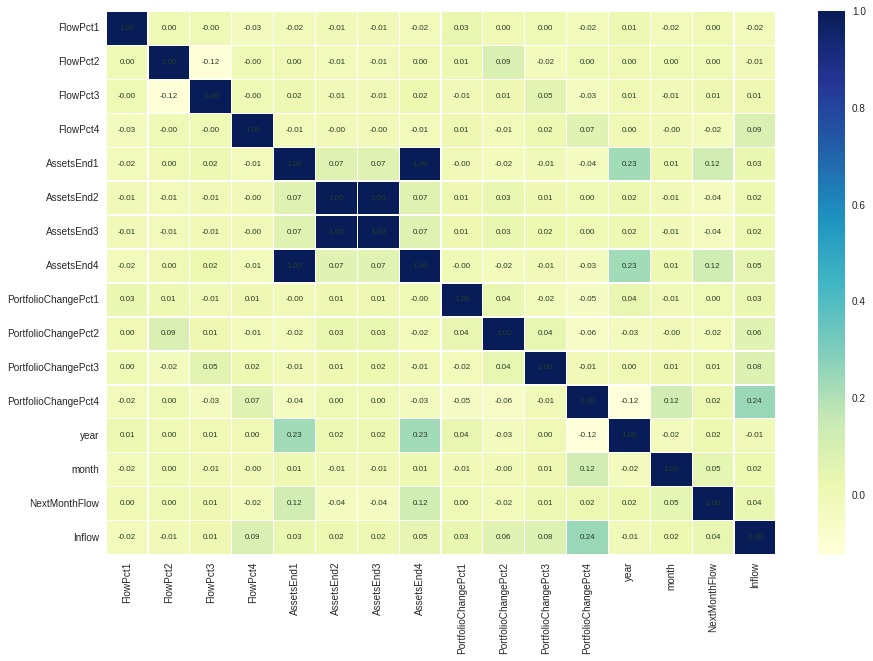

In [ ]:
# Check the correlation of the features 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
corr = data2.corr()
sns.heatmap(corr,linewidths=.2, cmap="YlGnBu", 
                 annot=True,
                 fmt=".2f",
                 annot_kws={'size':8,'weight':'normal', 'color':'#253D24'})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data2 = pd.get_dummies(data2)

In [ ]:
data2 = data2.reset_index(drop=True)
data2

,FlowPct1,FlowPct2,FlowPct3,FlowPct4,AssetsEnd1,AssetsEnd2,AssetsEnd3,AssetsEnd4,PortfolioChangePct1,PortfolioChangePct2,...,Industry_Mid Cap Blend,Industry_Mid Cap Growth,Industry_Mid Cap Value,Industry_Real Estate,Industry_Small Cap Blend,Industry_Small Cap Growth,Industry_Small Cap Value,Industry_Technology,Industry_Telecom,Industry_Utilities
0,6.8877,3.1609,-0.6022,-9.5029,365.747363,376.895214,367.731276,342.463192,1.9393,-0.1130,...,0,0,0,0,0,0,0,0,0,0
1,0.0000,11.1578,0.0000,11.1578,353.551743,380.566108,382.711351,389.790653,3.2378,-3.5170,...,0,0,0,0,0,0,0,0,0,0
2,0.6584,-6.9428,-4.0455,4.0095,1226.034803,1113.668457,1119.426080,1426.387768,-0.7101,-2.2222,...,0,0,0,0,0,0,0,0,0,0
3,-6.7927,-2.7356,2.0618,-1.9407,1360.070894,1307.920822,1398.830639,1360.132199,2.1434,-1.0987,...,0,0,0,0,0,0,0,0,0,0
4,-5.8893,3.0092,-0.2588,2.9431,1286.578357,1361.731888,1254.982939,1293.819947,0.4815,2.8320,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,-0.3026,-0.0732,-0.4560,-0.1859,14739.462527,14597.096789,14473.057879,14121.270467,-0.1562,-0.8926,...,0,0,0,0,0,0,0,0,0,1
7488,-0.3197,-0.2149,-0.1768,0.0272,14498.061035,13939.886858,14457.839909,14371.602536,2.9829,-3.6350,...,0,0,0,0,0,0,0,0,0,1
7489,-0.1423,-0.3798,-0.2580,-0.2206,13752.934773,13660.789697,13870.693964,13742.554326,-4.1624,-0.2901,...,0,0,0,0,0,0,0,0,0,1
7490,-0.2245,-0.3609,-0.5072,-0.2621,13317.818449,13350.409748,13086.205981,13178.058222,-2.8661,0.6056,...,0,0,0,0,0,0,0,0,0,1


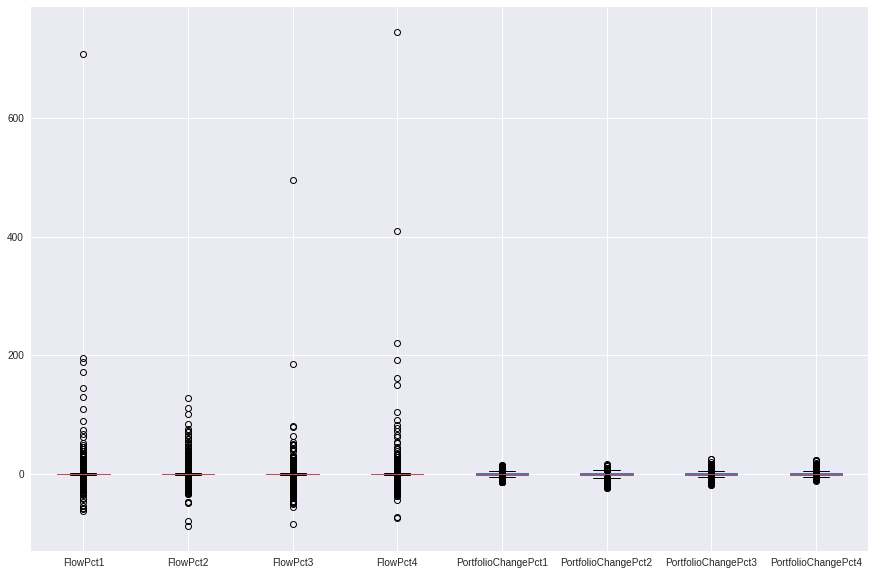

In [ ]:
# Check outliers
# Plot the boxplot od ratio features which are within the same scale
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
data2.boxplot(column= [i for i in data2[['FlowPct1', 'FlowPct2','FlowPct3','FlowPct4', 
       'PortfolioChangePct1', 'PortfolioChangePct2', 'PortfolioChangePct3', 'PortfolioChangePct4']].columns.tolist()]);
# plt.ylim([-50, 100])

# 'AssetsEnd1', 'AssetsEnd4',

In [ ]:
# Winsorizing the ratioa variables at 1% and 99% values
from scipy.stats.mstats import winsorize

data2['FlowPct1'] = winsorize(data2['FlowPct1'], limits = [0.01,0.01])
data2['FlowPct2'] = winsorize(data2['FlowPct2'], limits = [0.01,0.01])
data2['FlowPct3'] = winsorize(data2['FlowPct3'], limits = [0.01,0.01])
data2['FlowPct4'] = winsorize(data2['FlowPct4'], limits = [0.01,0.01])
data2['PortfolioChangePct1'] = winsorize(data2['PortfolioChangePct1'], limits = [0.01,0.01])
data2['PortfolioChangePct2'] = winsorize(data2['PortfolioChangePct2'], limits = [0.01,0.01])
data2['PortfolioChangePct3'] = winsorize(data2['PortfolioChangePct3'], limits = [0.01,0.01])
data2['PortfolioChangePct4'] = winsorize(data2['PortfolioChangePct4'], limits = [0.01,0.01])


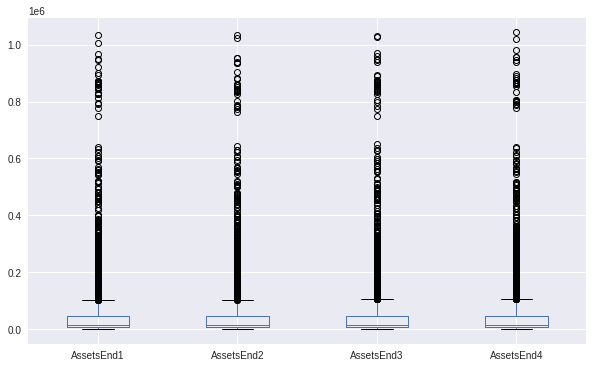

In [ ]:
# Check outliers
# Plot the boxplot od ratio features which are within the same scale
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
data2.boxplot(column= [i for i in data2[['AssetsEnd1', 'AssetsEnd2', 'AssetsEnd3', 'AssetsEnd4']].columns.tolist()]);
# plt.ylim([-50, 100])

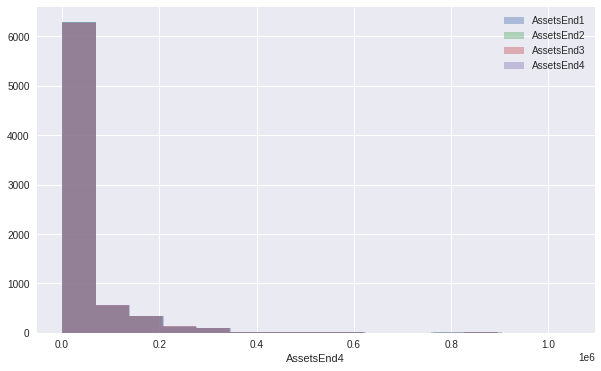

In [ ]:
# There are many outliers and the data is right-skewed.
plt.figure(figsize=(10,6))
sns.distplot(data2['AssetsEnd1'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd2'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd3'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd4'], bins = 15, kde = False)
fig.legend(labels = ['AssetsEnd1','AssetsEnd2','AssetsEnd3','AssetsEnd4'])

In [ ]:
# Here we need to use Log transformation to transform data to normal or close to normal
import numpy as np

AssetsEnd1_log = np.log(data2['AssetsEnd1'])
AssetsEnd1_log = np.log(data2['AssetsEnd2'])
AssetsEnd1_log = np.log(data2['AssetsEnd3'])
AssetsEnd4_log = np.log(data2['AssetsEnd4'])

data2['AssetsEnd1_log'] = AssetsEnd1_log
data2['AssetsEnd2_log'] = AssetsEnd1_log
data2['AssetsEnd3_log'] = AssetsEnd1_log
data2['AssetsEnd4_log'] = AssetsEnd4_log

data2 = data2.drop(['AssetsEnd1', 'AssetsEnd2','AssetsEnd3','AssetsEnd4'], axis=1)

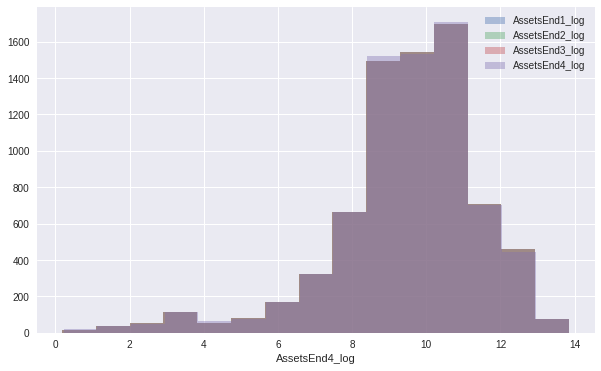

In [ ]:
# There are many outliers and the data is right-skewed.
plt.figure(figsize=(10,6))
sns.distplot(data2['AssetsEnd1_log'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd2_log'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd3_log'], bins = 15, kde = False)
fig = sns.distplot(data2['AssetsEnd4_log'], bins = 15, kde = False)
fig.legend(labels = ['AssetsEnd1_log','AssetsEnd2_log','AssetsEnd3_log','AssetsEnd4_log'])

In [ ]:
data2.shape

(7492, 38)

In [ ]:
label = data2[['NextMonthFlow']]
data2 = data2.drop(['NextMonthFlow'],axis=1)

(0.0, 600.0)

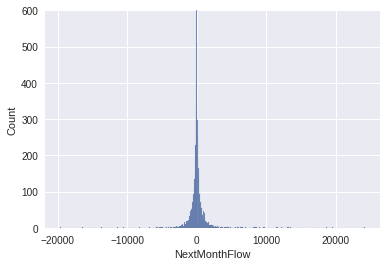

In [ ]:
import seaborn as sns

sns.histplot(label['NextMonthFlow'])
plt.ylim((0,600))

In [ ]:
classes = []

for i in label['NextMonthFlow'].values: 
  if i < -100 :
    classes.append('-1')
  elif i >=-100 and i<=100:
    classes.append('0')
  elif i >100:
    classes.append('1')

In [ ]:
label['classes'] = classes

In [ ]:
label

,NextMonthFlow,classes
0,39.448926,0
1,165.453872,1
2,-134.278695,-1
3,4.147121,0
4,299.481155,1
...,...,...
7487,-97.042509,0
7488,-138.551304,-1
7489,-220.938402,-1
7490,-195.533057,-1


In [ ]:
print('The number of Flow located within (,-100) is'.format(), len(label.loc[label['NextMonthFlow']<-100] == True))
print('The number of Flow located within [-100,100] is'.format(),len(label.loc[(label['NextMonthFlow']>=-100) & (label['NextMonthFlow']<=100)] == True))
print('The number of Flow located within (100,) is'.format(),len(label.loc[(label['NextMonthFlow']>100) & (label['NextMonthFlow']<25000)] == True))

The number of Flow located within (,-100) is 2589
The number of Flow located within [-100,100] is 2288
The number of Flow located within (100,) is 2615


In [ ]:
pd.value_counts(label['classes'])

1     2615
-1    2589
0     2288
Name: classes, dtype: int64

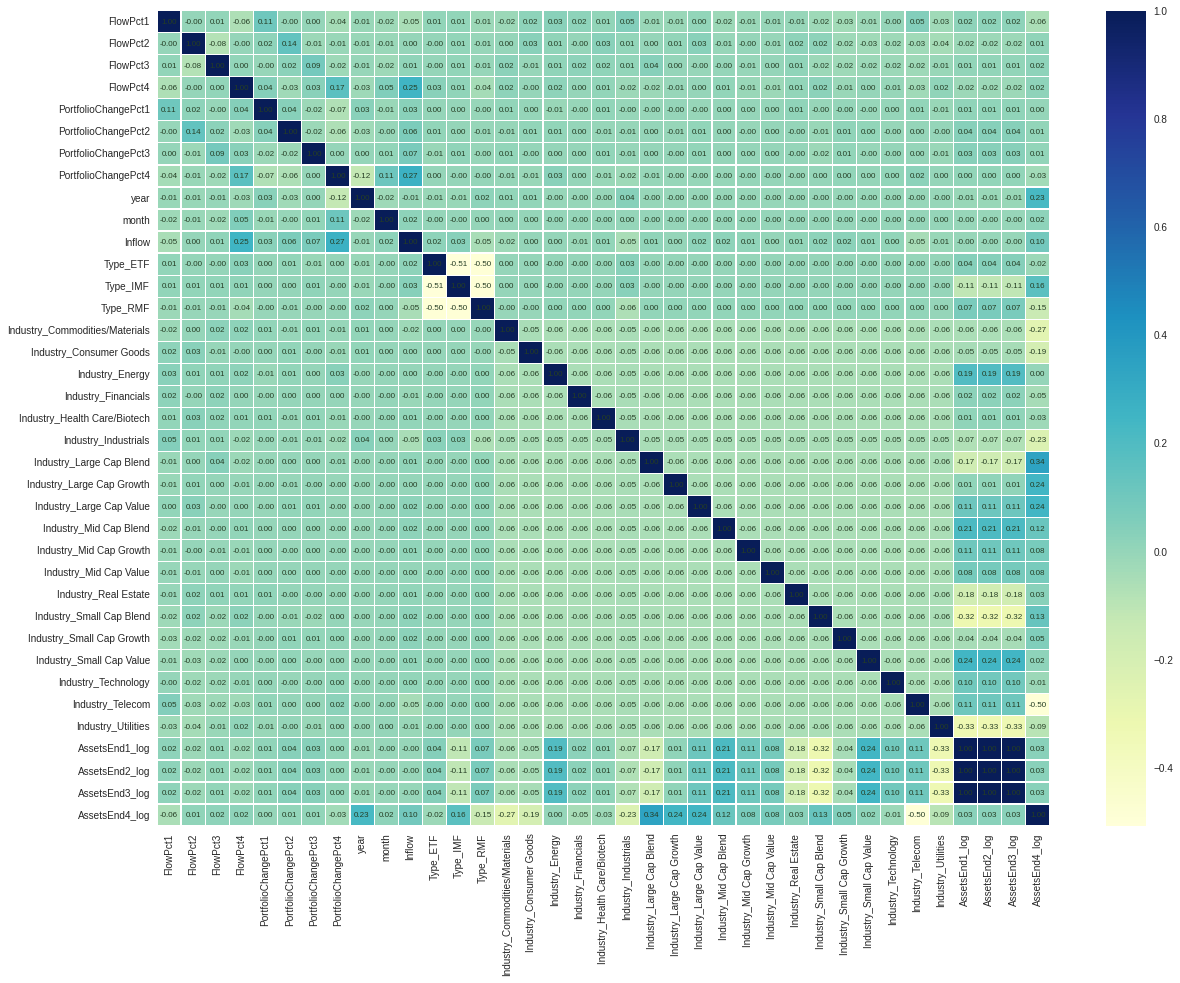

In [ ]:
# Check the correlation of the features 
import seaborn as sns

plt.figure(figsize=(20,15))
corr = data2.corr()
sns.heatmap(corr,linewidths=.2, cmap="YlGnBu", 
                 annot=True,
                 fmt=".2f",
                 annot_kws={'size':8,'weight':'normal', 'color':'#253D24'})



In [ ]:
def df_norm(df, cols):
    df_n = df[cols]
    for col in cols:
        ma = df_n[col].max()
        mi = df_n[col].min()
        df_n[str(col) + '_n'] = (df_n[col] - mi) / (ma - mi)
    return df_n



In [ ]:
data2['year'] = 2022 - data2['year']

In [ ]:
data2

,FlowPct1,FlowPct2,FlowPct3,FlowPct4,PortfolioChangePct1,PortfolioChangePct2,PortfolioChangePct3,PortfolioChangePct4,year,month,...,Industry_Small Cap Blend,Industry_Small Cap Growth,Industry_Small Cap Value,Industry_Technology,Industry_Telecom,Industry_Utilities,AssetsEnd1_log,AssetsEnd2_log,AssetsEnd3_log,AssetsEnd4_log
0,6.8877,3.1609,-0.6022,-9.5029,1.9393,-0.1130,-1.8291,2.6315,16,1,...,0,0,0,0,0,0,5.907352,5.907352,5.907352,5.836164
1,0.0000,11.1578,0.0000,11.1578,3.2378,-3.5170,0.5636,1.8497,16,2,...,0,0,0,0,0,0,5.947281,5.947281,5.947281,5.965610
2,0.6584,-6.9428,-4.0455,4.0095,-0.7101,-2.2222,4.5625,1.9107,16,3,...,0,0,0,0,0,0,7.020571,7.020571,7.020571,7.262900
3,-6.7927,-2.7356,2.0618,-1.9407,2.1434,-1.0987,4.8888,-0.8257,16,4,...,0,0,0,0,0,0,7.243392,7.243392,7.243392,7.215337
4,-5.8893,3.0092,-0.2588,2.9431,0.4815,2.8320,-7.5803,1.3907,16,5,...,0,0,0,0,0,0,7.134877,7.134877,7.134877,7.165354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,-0.3026,-0.0732,-0.4560,-0.1859,-0.1562,-0.8926,-0.3937,-1.6336,6,8,...,0,0,0,0,0,1,9.580044,9.580044,9.580044,9.555437
7488,-0.3197,-0.2149,-0.1768,0.0272,2.9829,-3.6350,3.8924,-0.6236,6,9,...,0,0,0,0,0,1,9.578992,9.578992,9.578992,9.573009
7489,-0.1423,-0.3798,-0.2580,-0.2206,-4.1624,-0.2901,1.7946,-0.7032,6,10,...,0,0,0,0,0,1,9.537534,9.537534,9.537534,9.528252
7490,-0.2245,-0.3609,-0.5072,-0.2621,-2.8661,0.6056,-1.4717,-0.0082,6,11,...,0,0,0,0,0,1,9.479314,9.479314,9.479314,9.486308


In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(np.array(data2), np.array(label['classes']), test_size=0.2, random_state=888)

In [ ]:
models=[KNeighborsClassifier(),
        LogisticRegression(penalty='l2'),
        RandomForestClassifier(n_estimators=15),
        tree.DecisionTreeClassifier(),
        GradientBoostingClassifier(n_estimators=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        SVC(kernel='rbf', probability=True),
        ]
        
models_str=['KNN',
            'LogisticRegression',
            'RandomForest',
            'DecisionTree',
            'GBDT',
            'AdaBoost',
            'GaussianNB',
            'LinearDiscriminantAnalysis',
            'QuadraticDiscriminantAnalysis',
            'SVM']
score_=[]

In [ ]:
for name,model in zip(models_str,models):
    print('Start Training：'+name)
    model=model
    model.fit(Xtrain,ytrain)
    y_pred=model.predict(Xtest)
    # pre_y_train = clf.predict(X_train)
    pre_y_test = model.predict(Xtest)
    # print("lr Metrics : {0}".format(precision_recall_fscore_support(ytest, pre_y_test)))  
    # score=model.score(Xtest,ytest)
    # score_.append(str(score)[:5])
    # print(name +'Score:'+str(score))


    from sklearn.metrics import classification_report
    from sklearn import metrics

    true_false = (pre_y_test == ytest)
    accuracy = np.count_nonzero(true_false) / float(len(ytest))
    print()
    print("accuracy is %f" % accuracy)

    # precision    recall  f1-score
    print()
    print(metrics.classification_report(ytest, pre_y_test))

    # 混淆矩阵
    print("Confusion Matrix...")
    print(metrics.confusion_matrix(ytest, pre_y_test))

Start Training：KNN

accuracy is 0.521014

              precision    recall  f1-score   support

          -1       0.48      0.64      0.55       507
           0       0.57      0.53      0.55       459
           1       0.53      0.39      0.45       533

    accuracy                           0.52      1499
   macro avg       0.53      0.52      0.52      1499
weighted avg       0.53      0.52      0.52      1499

Confusion Matrix...
[[327  71 109]
 [141 244  74]
 [213 110 210]]
Start Training：LogisticRegression

accuracy is 0.581721

              precision    recall  f1-score   support

          -1       0.55      0.51      0.53       507
           0       0.68      0.65      0.67       459
           1       0.53      0.59      0.56       533

    accuracy                           0.58      1499
   macro avg       0.59      0.58      0.59      1499
weighted avg       0.58      0.58      0.58      1499

Confusion Matrix...
[[261  59 187]
 [ 75 297  87]
 [141  78 314]]
Start T